先导入必要的module，使用matplotlib进行可视化，使用np.arrray存储矩阵，不调用额外的方法，主要部分还是自己实现

In [22]:
import numpy as np
import matplotlib.pyplot as plt

从文件中读取数据，使用array将其存储为数组，数据类型为float

In [23]:
with open('./point.txt', 'r') as file:
    lines = file.readlines()

    # 将数据转换为NumPy数组
    data = np.zeros((len(lines), 2))
    for i, line in enumerate(lines):
        elements = line.strip().split()
        data[i, 0] = float(elements[0])
        data[i, 1] = float(elements[1])
    # data = np.array([elements for line in lines for elements in line.strip().split()], dtype=float)
print(data)

[[-9.      0.127 ]
 [-8.      0.9134]
 [-7.      0.6324]
 [-6.      0.0975]
 [-5.      0.2785]
 [-4.      0.5469]
 [-3.      0.9575]
 [-2.      0.9649]
 [-1.      0.1576]
 [ 0.      0.9706]
 [ 1.      0.9572]
 [ 2.      0.4854]
 [ 3.      0.8003]
 [ 4.      0.1419]
 [ 5.      0.4218]
 [ 6.      0.9157]
 [ 7.      0.9157]
 [ 8.      0.7922]
 [ 9.      0.9595]
 [10.      0.6557]
 [11.      0.8147]]


下面就是根据上述数据创建系数矩阵A和向量D

使用已经推得的关系：
$$
\begin{cases}
\lambda_i = \frac{h_i}{h_i + h_{i-1}} \\
\mu_i = 1 - \lambda_i \\
d_i = \frac{6}{h_i + h_{i-1}} \big( \frac{y_{i+1} - y_i}{h_i} - \frac{y_i - y_{i-1}}{h_{i-1}} \big) =6f[x_{i-1}, x_i, x_{i+1}]
\end{cases}
$$

在此情况下，$\lambda = \mu = \frac{1}{2}, d_i = \frac{(y_{i+1} - y_{i-1})}{2}$

定义一个相对general的类解决该问题，而不是单适用于本情形

得到M之后根据已推得的公式：
$$
S_i(x) = \frac{(x_{i+1} - x)^3 M_i + (x - x_i)^3 M_{i+1}}{6 h_i} + \frac{y_i(x_{i+1} - x) + y_{i+1}(x - x_i)}{h_i} - \frac{h_i[(M_i(x_{i+1} - x) + M_{i+1}(x - x_i)]}{6}
$$

In [24]:
class Spline:
    def __init__(self, points):
        self.points = points
        self.size = len(self.points)
        self.h = [self.points[i + 1][0] - self.points[i][0] for i in range(self.size-1)]
        self.lambda_li = [(self.h[i+1] / (self.h[i] + self.h[i + 1])) for i in range(self.size-2)]
        self.miu = [1 - self.lambda_li[i] for i in range(self.size-2)]
        self.d =[(6 / (self.h[i] + self.h[i - 1]) * ((self.points[i + 1][1] - self.points[i][1]) / self.h[i] - (self.points[i][1] - self.points[i - 1][1]) / self.h[i - 1])) for i in range(1, self.size-1)]
        self.func_points = [] # 这个用于存储在各个点上的坐标

        
    def thomas_algorithm(self):
        a = [2.0 for _ in range(self.size - 2)]
        b = self.lambda_li[0:self.size-3]
        c = self.miu[1:self.size-2]
        d = self.d[0:self.size-1]
        n = len(d)
        
        c_star = np.zeros(n-1)
        d_star = np.zeros(n)
        
        c_star[0] = c[0] / a[0]
        d_star[0] = d[0] / a[0]
        
        for i in range(1, n):
            m = 1 / (a[i] - b[i-1] * c_star[i-1])
            if i < n - 1:
                c_star[i] = c[i] * m
            d_star[i] = (d[i] - d_star[i-1] * b[i-1]) * m
        
        x = np.zeros(n)
        x[-1] = d_star[-1]
        
        for i in range(n - 2, -1, -1):
            x[i] = d_star[i] - c_star[i] * x[i + 1]
        
        return x
    
    def calc_M(self):
        self.M = [0] + list(self.thomas_algorithm()) + [0]
        self.formatted_M = [round(val, 2) for val in self.M]
    
    def special_func_for_spline(self, i):
        # 这个函数根据index i返回一个区间内的1000个函数及函数值，依据上面的根据M表达的插值公式
        # 注意 i 表示的是第i + 1个
        
        x_start = self.points[i, 0]
        x_end = self.points[i + 1, 0]
        h = self.h[i]
        y1 = self.points[i, 1]
        y2 = self.points[i + 1, 1]
        m1 = self.M[i]
        m2 = self.M[i + 1]
        return_points = np.linspace(x_start, x_end, 1000, endpoint=False)
        # print(x_start, return_points)
        def func(m1, m2, y1, y2, x_start, x_end, h, x):
            # 这是一个使用M_i, M_i+1两个参数和x_start, x_end计算对应点x函数指的函数
            term1 = ((x_end - x)**3 * m1 + (x - x_start)**3 * m2) / (6 * h)
            term2 = (y1 * (x_end - x) + y2 * (x - x_start)) / h
            term3 = (h * ((m1 * (x_end - x)) + (m2 * (x - x_start)))) / 6
            return term1 + term2 - term3
        
        return_vals = np.array([func(m1, m2, y1, y2, x_start, x_end, h, x) for x in return_points])
        return np.column_stack((return_points, return_vals))

    
    def solve_and_plot(self):
        self.calc_M()
        
        for i in range(self.size - 1):
            points_this_set = self.special_func_for_spline(i)
            self.func_points.extend(points_this_set.tolist())
            plt.plot(points_this_set[:, 0], points_this_set[:, 1])
            
        plt.xlabel('x')
        plt.ylabel('S(x)')
        plt.title('Spline?')
        plt.grid(True)
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.show()
        
    def __sub__(self, other):
        self_points_array = np.array(self.func_points)
        other_points_array = np.array(other.func_points)
        
        sub_points = self_points_array[:, 1] - other_points_array[:, 1]  # 计算第二列的差值
        x_values = self_points_array[:, 0]  # x 值取自 func_points 的第一列
        
        plt.plot(x_values, sub_points)
        plt.xlabel('x')
        plt.ylabel('Sub(x)')
        plt.title('Error')
        plt.grid(True)
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.show()
        
        sub_points = np.column_stack((x_values, sub_points))
        for i in range(0, len(sub_points), 100):
            print(sub_points[i])
        

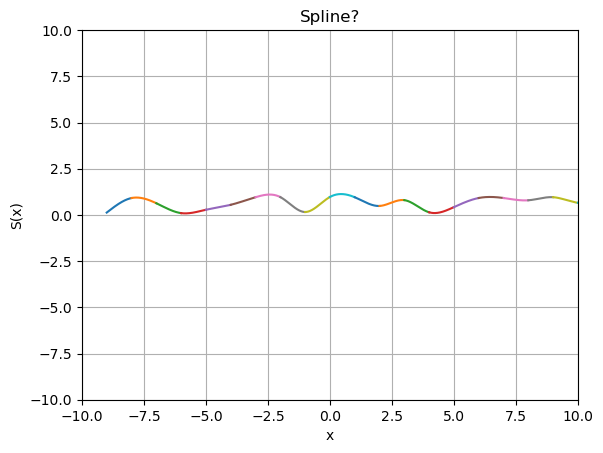

[0, -1.5254432929911972, -0.3026268280352117, 1.2125506051320445, -0.2521755924929668, 0.3205517648398225, -0.17683146686632356, -2.0324258973745284, 3.4183350563644366, -1.9191143280832184, -0.7002777440315622, 1.9698253042094667, -2.458823472806305, 2.0256685870157543, -0.014050875256712031, -0.6854650859889065, -0.20748878078766125, 0.774420209139552, -1.1453920557705473, 0.980548013942637, 0]


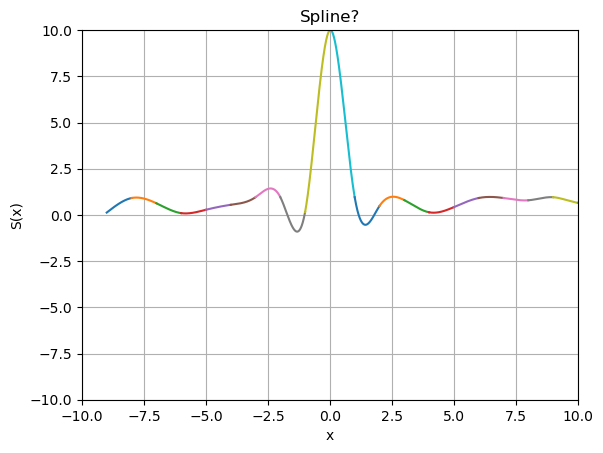

[0, -1.5277576665851396, -0.29336933365944223, 1.177835001222909, -0.12257067123219437, -0.16315231629413174, 1.628379936408721, -8.769567429340752, 28.56168978095429, -41.578991694476414, 24.443076996951394, -4.767316293329153, -0.6536118236347783, 1.5419635878682658, 0.11555747216171491, -0.720193476515126, -0.19818356610121016, 0.771927740919967, -1.144727397578658, 0.9803818493946647, 0]


In [25]:
import copy

sample1 = Spline(data)
sample1.solve_and_plot()
print(sample1.M)
# sample1.func_points

data1 = copy.deepcopy(data)
data1[9, 1] = 10.
# print(data1)
sample2 = Spline(data1)
sample2.solve_and_plot()
print(sample2.M)

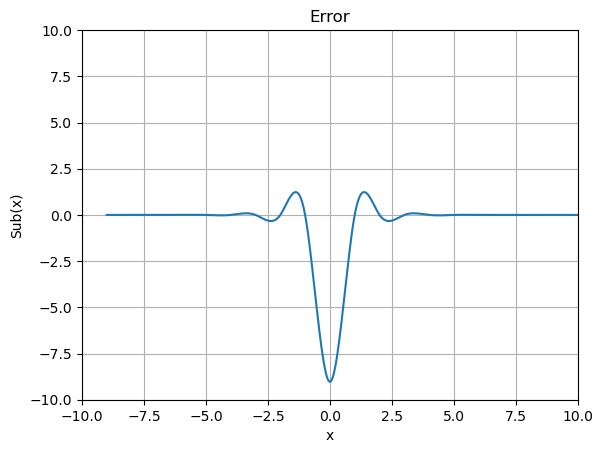

[-9.  0.]
[-8.90000000e+00 -3.81871643e-05]
[-8.8000000e+00 -7.4059955e-05]
[-8.70000000e+00 -1.05303999e-04]
[-8.60000000e+00 -1.29604921e-04]
[-8.5000000e+00 -1.4464835e-04]
[-8.4000000e+00 -1.4811991e-04]
[-8.30000000e+00 -1.37705229e-04]
[-8.20000000e+00 -1.11089933e-04]
[-8.10000000e+00 -6.59596474e-05]
[-8.  0.]
[-7.90000000e+00  8.67890098e-05]
[-7.80000000e+00  1.85149888e-04]
[-7.70000000e+00  2.83510765e-04]
[-7.60000000e+00  3.70299775e-04]
[-7.50000000e+00  4.33945049e-04]
[-7.40000000e+00  4.62874719e-04]
[-7.30000000e+00  4.45516917e-04]
[-7.20000000e+00  3.70299775e-04]
[-7.10000000e+00  2.25651425e-04]
[-7.00000000e+00  1.11022302e-16]
[-6.90000000e+00 -3.08968875e-04]
[-6.80000000e+00 -6.66539595e-04]
[-6.70000000e+00 -1.02873906e-03]
[-6.60000000e+00 -1.35159418e-03]
[-6.50000000e+00 -1.59113185e-03]
[-6.40000000e+00 -1.70337897e-03]
[-6.30000000e+00 -1.64436244e-03]
[-6.20000000e+00 -1.37010917e-03]
[-6.10000000e+00 -8.36646054e-04]
[-6.00000000e+00  2.77555756e-17]


In [26]:
sample1 - sample2

In [ ]:
# class Spline:
#     def __init__(self, data) -> None:
#         self.points = data
#         self.size = (len(data) - 2) # 此处，一共有n+1个采样点，最终构造的矩阵是n-1 * n-1的矩阵
#         # self.Lambda = []
#         # self.Mu = []
#         self.H = [data[i + 1, 0] - data[i, 0] for i in range(len(data) - 1)]
#         # print(self.H, len(self.H))
#         self.A = np.zeros((self.size, self.size))
#         # print(self.A)
#         self.D = []
#         for i in range(self.size):
#             tmp_lambda = self.H[i + 1] / (self.H[i + 1] + self.H[i])
#             # print('tmp lambda: ', tmp_lambda)
#             tmp_d = (6 / (self.H[i + 1] + self.H[i])) * ( (data[i + 2, 1] - data[i + 1, 1]) / self.H[i + 1] - (data[i + 1, 1] - data[i, 1]) / self.H[i] )
#             self.D.append(tmp_d)
#             # print(tmp_d)
#             self.A[i, i] = 2
#             if i < self.size - 1:
#                 self.A[i, i + 1] = tmp_lambda
#             if i > 0:
#                 self.A[i, i - 1] = 1 - tmp_lambda
#         # print('A:', self.A, len(self.A))
#         print('D', self.D, len(self.D))
        
        
#     def __thomas_alg(self) -> None:
#         ''' 
#         使用追赶法将三对角矩阵做LU分解
#         '''
#         self.L = np.zeros((self.size, self.size))
#         self.U = np.zeros((self.size, self.size))
#         self.U[0, 0] = self.A[0, 0]
#         for i in range(self.size):
#             self.L[i, i] = 1
#             if i > 0:
#                 self.L[i, i - 1] = self.A[i, i - 1] / self.U[i - 1, i - 1]
#                 self.U[i, i] = self.A[i, i] - self.L[i, i - 1] * self.U[i - 1, i]
#             if i < self.size - 1:
#                 self.U[i, i + 1] = self.A[i, i + 1]
#             # 追的时候L可以直接计算
#         print('L')
#         print(self.L)
#         print('U')
#         print(self.U)
        
        
#     def __coefficients(self):
#         # 上面求出L，U，接下来求解M并得到多项式
#         self.__thomas_alg()
#         # 先求解Ly = d:
#         y = np.zeros(self.size)
#         y[0] = self.D[0]
#         for i in range(1, self.size):
#             y[i] = self.D[i] - np.dot(self.L[i, :i], y[:i])
#         self.M = np.zeros(self.size)
#         self.M[-1] = y[-1] / self.U[-1, -1]
        
#         for i in range(-2, -self.size, -1):
#             self.M[i] = (y[i] - np.dot(self.U[i, i:], y[i:])) / self.U[i, i]
#         print('m:', self.M)
        
    
#     def special_func_for_spline(self, i):
#         # 这个函数根据index i返回一个区间内的1000个函数及函数值，依据上面的根据M表达的插值公式
#         # 注意 i 表示的是第i + 1个
        
#         x_start = self.points[i, 0]
#         x_end = self.points[i + 1, 0]
#         h = self.H[i]
#         y1 = self.points[i, 1]
#         y2 = self.points[i + 1, 1]
#         m1 = self.M[i]
#         m2 = self.M[i + 1]
#         return_points = np.linspace(x_start, x_end, 1000, endpoint=False)
#         # print(x_start, return_points)
#         def func(m1, m2, y1, y2, x_start, x_end, h, x):
#             # 这是一个使用M_i, M_i+1两个参数和x_start, x_end计算对应点x函数指的函数
#             term1 = ((x_end - x)**3 * m1 + (x - x_start)**3 * m2) / (6 * h)
#             term2 = (y1 * (x_end - x) + y2 * (x - x_start)) / h
#             term3 = (h * ((m1 * (x_end - x)) + (m2 * (x - x_start)))) / 6
#             return term1 + term2 - term3
#         return_vals = np.array([func(m1, m2, y1, y2, x_start, x_end, h, x) for x in return_points])
#         return np.column_stack((return_points, return_vals))

    
#     def solve_and_plot(self):
#         self.__coefficients()
        
#         for i in range(self.size - 1):
#             points_this_set = self.special_func_for_spline(i)
#             plt.plot(points_this_set[:, 0], points_this_set[:, 1])
            
#         plt.xlabel('x')
#         plt.ylabel('S(x)')
#         plt.title('Spline?')
#         plt.grid(True)
#         plt.xlim(-10, 10)
#         plt.ylim(-10, 10)
#         plt.show()
            
#         # 最后，通过求得的M得到最终的函数
        
        
        

# sample = Spline(data)
# # print(sample.special_func_for_spline(0))
# # sample.coefficients()
# sample.solve_and_plot()
